#1. Header with Contributions

##An Analysis of Goodreads Book Reviews
Fall 2024 Data Science Project

by:
*   Alec Ding, UID: 118754499
*   Katherine Krotkov, UID: 118852690
*   Anvay Panguluri, UID: 119227169
*   Tanmay Panguluri, UID: 119227213

Contributions:
*   Alec Ding
  * []
*   Katherine Krotkov
  * []
*   Anvay Panguluri
  * []
*   Tanmay Panguluri
  * Worked on the ML algorithm design/development and on the ML algorithm training and test data analysis. Used data prepared in section 4 to write section 5: Primary Analysis.

#2. Introduction

#3. Data Curation

[This](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks/data) is the source of our dataset. The site is Kaggle, a site where high-quality public datasets are available.

We first add the required libraries to parse in the dataset:

In [42]:
import pandas as pd
import gdown

And then we load the dataset into a pandas dataframe.

In [43]:
# Downloading the dataset; this cell needs only to be run once to get the csv
# file into the Google Colab Notebook.
url = "https://drive.google.com/uc?id=1yexdWwAjBcYM58T-J2J4d_pEhOx494FF"
output = "books.csv"
gdown.download(url, output, quiet=False)

# Loading the data into a DataFrame.
books_df = pd.read_csv("books.csv", on_bad_lines='skip')

Downloading...
From: https://drive.google.com/uc?id=1yexdWwAjBcYM58T-J2J4d_pEhOx494FF
To: /content/books.csv
100%|██████████| 1.56M/1.56M [00:00<00:00, 128MB/s]


The data is now ready for analysis.

#4. Exploratory Data Analysis

We will now examine the dataset.

In [44]:
books_df.shape

(11123, 12)

As can be seen, there are 11,123 records and 12 features in the dataset.

Here is a preview of the dataset:

In [45]:
books_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


We can explicitly give the columns:

In [46]:
books_df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

and datatypes of those columns:

In [47]:
books_df.dtypes

,0
bookID,int64
title,object
authors,object
average_rating,float64
isbn,object
isbn13,int64
language_code,object
num_pages,int64
ratings_count,int64
text_reviews_count,int64


The datatypes are in a mix of strings and integers. Since we wish to perform linear regression on this data (which will be explained later), we will need to transform all the string data into numerical data. This can be accomplished through label encoding, which will be done later.

We can also examine some summary statistics of the columns with numerical data where such summary statistics make sense. That is to say, taking the median or average of ISBN numbers makes little sense, since ISBNs are not continuous variables like num_pages, ratings_counts, or average_ratings is.

In [48]:
books_df[['average_rating', '  num_pages', 'ratings_count', 'text_reviews_count']].describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000
mean,3.934075,336.405556,1.794285e+04,542.048099
std,0.350485,241.152626,1.124992e+05,2576.619589
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,47.000000
75%,4.140000,416.000000,5.000500e+03,238.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


You might notice that the column '  num_pages' is incorrectly formatted; there are leading spaces. This can be solved by using the strip() function on all the column names.

In [49]:
books_df.columns = books_df.columns.str.strip()

In order to apply linear regression to the dataset, the columns we want to analyze have to be numerical. Some of the columns are in string or date form, which will not work.

So, these must be encoded.

First off, we can split the publication_date field into three new integer columns giving the year, month, and date of publication.

In [50]:
import datetime as dt
books_df['publication_date'] = pd.to_datetime(books_df['publication_date'], format="%m/%d/%Y", errors="coerce")

books_df['year'] = books_df['publication_date'].dt.year
books_df['month'] = books_df['publication_date'].dt.month
books_df['day'] = books_df['publication_date'].dt.day

Now, we will perform label encoding for the remaining columns that must be transformed: title, language_code, authors, and publisher.



In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
books_df['language_code_encoded'] = le.fit_transform(books_df['language_code'])
books_df['authors_encoded'] = le.fit_transform(books_df['authors'])
books_df['publisher_encoded'] = le.fit_transform(books_df['publisher'])
books_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,year,month,day,language_code_encoded,authors_encoded,publisher_encoded
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2006.0,9.0,16.0,5,2626,1778
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2004.0,9.0,1.0,5,2626,1778
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,2003.0,11.0,1.0,5,2622,1773
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,2004.0,5.0,1.0,5,2626,1778
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,2004.0,9.0,13.0,5,2626,1773


###Now will will examine the data for outliers.

First, we can examine num_pages.

<Axes: >

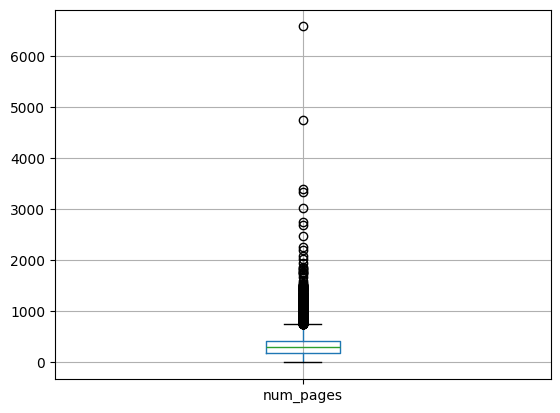

In [52]:
books_df[["num_pages"]].boxplot()

Clearly, there are some outliers which are skewing the data to the right. The bulk of the outliers are above around 700, so we can remove the records where num_pages is above 700.

<Axes: >

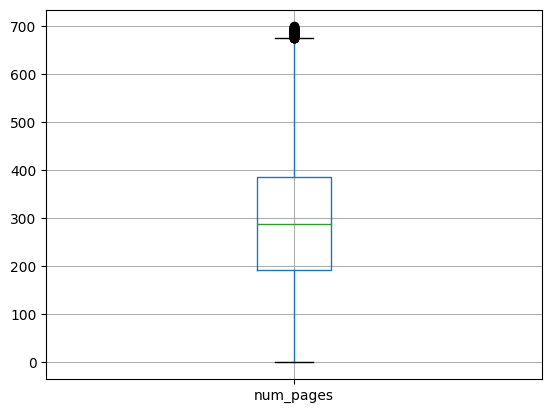

In [53]:
books_df = books_df[books_df["num_pages"] <= 700]
books_df[["num_pages"]].boxplot()

Similarly for ratings_count:

<Axes: >

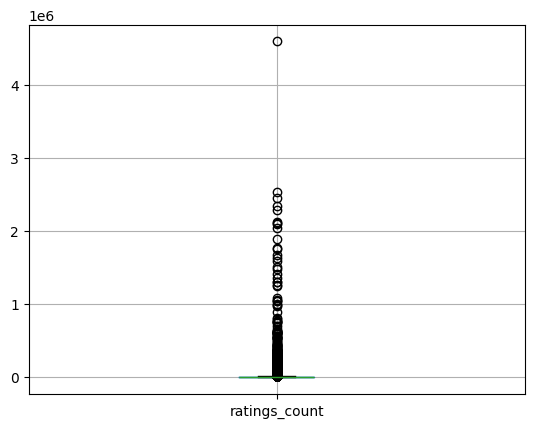

In [54]:
books_df[["ratings_count"]].boxplot()

Clearly there are many, many outliers, so we can remove all the outliers where ratings_count is above 3,000.

<Axes: >

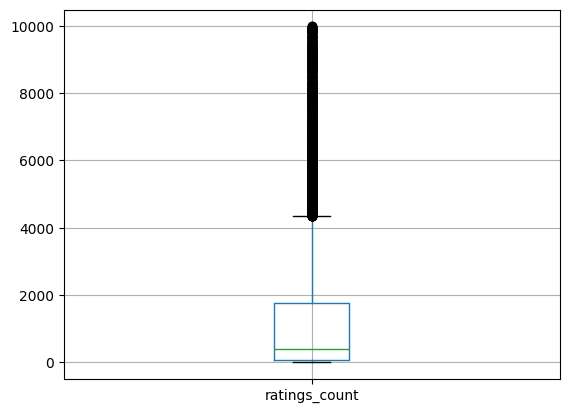

In [55]:
books_df = books_df[books_df["ratings_count"] <= 10000]
books_df[["ratings_count"]].boxplot()

And for text_reviews_count:

<Axes: >

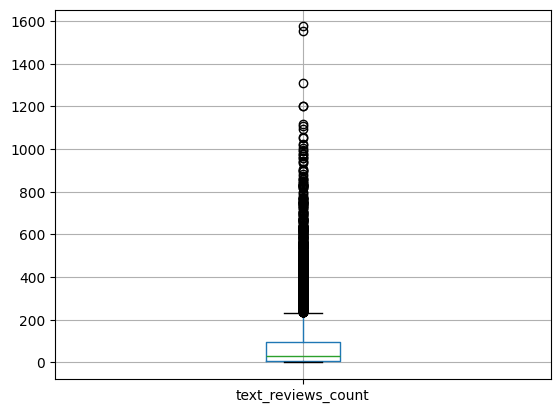

In [56]:
books_df[["text_reviews_count"]].boxplot()

Removing outliers:

<Axes: >

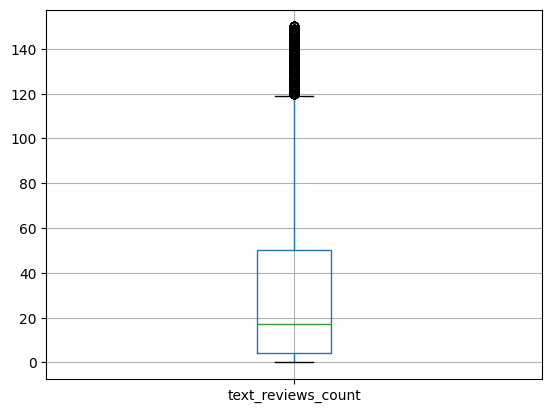

In [57]:
books_df = books_df[books_df["text_reviews_count"] <= 150]
books_df[["text_reviews_count"]].boxplot()

###We will now perform an exploratory data analysis through three hypothesis tests.


In [58]:
# Importing the required libraries to perform hypothesis tests:
import matplotlib.pyplot as plt
from scipy import stats

1. Let us use the ANOVA test to analyze the relationship between language and the number of reviews.

$H_0$: Language has no effect on the number of reviews.

$H_A$: Language has an effect on the number of reviews.

$\alpha$ = 0.05

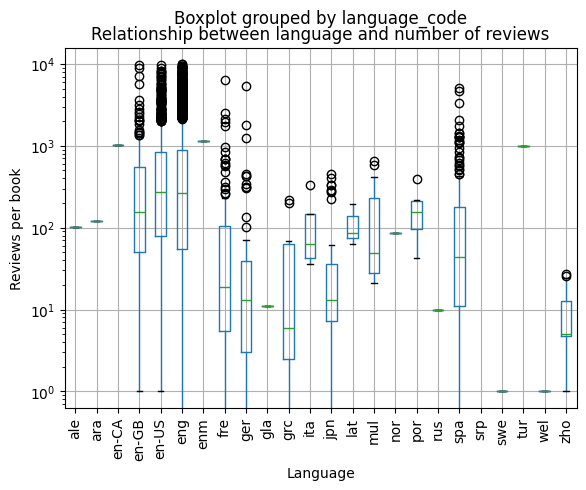

In [59]:
books_df[["language_code", "ratings_count"]].boxplot(by="language_code")
plt.xlabel("Language")
plt.ylabel("Reviews per book")
plt.title("Relationship between language and number of reviews")
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

As we can see from the boxplot, there is a decent variation between the languages for the number of reviews books get. There also appears to be a lot of extremely highly reviewed outlier books in the dataset as well.

In [60]:
# Performing the ANOVA test:
samples = [x[1] for x in books_df.groupby("language_code")["ratings_count"]]
f_val, p_val = stats.f_oneway(*samples)
p_val

1.95591772655826e-12

As can be seen by the p-value, which is lower than $\alpha$ (1.96E-12 < 0.05), language has a statistically significant effect on the number of reviews that a book has. This is likely due to different languages having a larger reader base than other, more niche languages, or simply that Goodreads is an English website, and that English-like Indo-European language are more supported and popular to host than other languages, which would be hosted on a different site.

2. Let us perform an ANOVA test to measure whether the means of the average rating for a publisher's set of books differ from each other.

$H_0$ : The mean average rating of books do not differ based on the books' publishers.

$H_A$ : The mean average rating of books do differ based on the books' publishers.

$\alpha$ = 0.05

In [61]:
# Performing the ANOVA test
test1_group = books_df.groupby("publisher")['average_rating'].apply(list)
f_statistic, p_value = stats.f_oneway(*test1_group)
f_statistic, p_value

(3.207275361029249, 4.4286115543795855e-241)

The p-value = 4.43E-241. Since the p-value is less than $\alpha$, therefore we reject the null hypothesis and conclude that the mean average rating of books do differ based on their publishers.

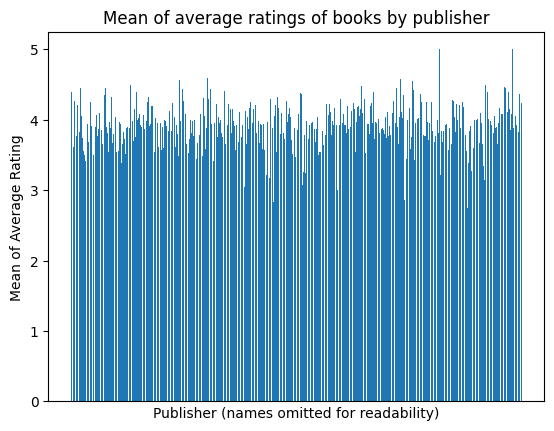

In [62]:
avg_rating_by_publisher = books_df.groupby("publisher")['average_rating'].mean()
avg_rating_by_publisher
plt.bar(avg_rating_by_publisher.index, avg_rating_by_publisher.values)
plt.title("Mean of average ratings of books by publisher")
plt.xticks([])
plt.xlabel("Publisher (names omitted for readability)")
plt.ylabel("Mean of Average Rating")
plt.show()

3. Z-Test for Relationship between Average Number of Pages and Language

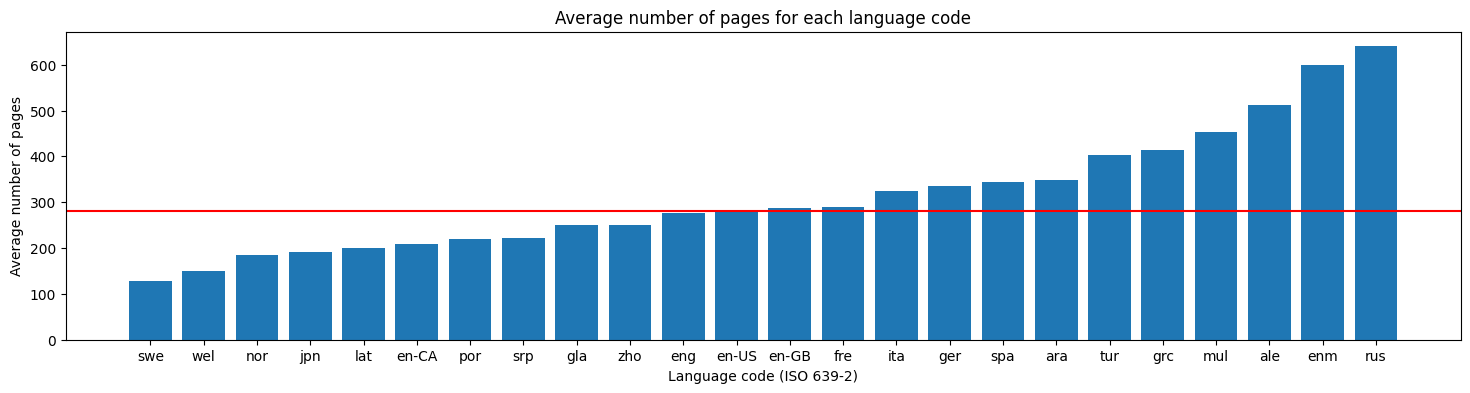

In [63]:
avg_page_per_language = books_df.groupby("language_code")['num_pages'].mean().sort_values()
plt.figure(1, [18, 4])
mean_pages = books_df['num_pages'].mean()
plt.title("Average number of pages for each language code")
plt.xlabel("Language code (ISO 639-2)")
plt.ylabel("Average number of pages")
plt.axline((0,mean_pages),slope=0,color="red")
plt.bar(avg_page_per_language.index, avg_page_per_language.values)
plt.show()

While it's clear that there are some big outliers, mainly "enm", which is Middle English, most of the values hover around the red line, which is the mean number of pages across all languages. The median, at 299 compared to the mean of approximately 336, is also quite close to the mean, so there isn't much of a skew; there are outliers on both ends, although the outliers on the higher end tend to deviate from the mean more than the outliers on the lower end.

To look at a concrete example, we can use a Z-test to see if the mean for Japanese is significantly different than the overall mean. Japanese is chosen because it's not incredibly close to the mean but not as much of an outlier as Middle English, and because there are more Japanese books in the database than those of many other languages. The below code shows that there are 46 books in Japanese in the data set, which is enough to satisfy the Central Limit Theorem for a Z-test.

In [64]:
len(books_df[books_df['language_code'] == 'jpn'])

46

$H_0$ : The mean number of pages for Japanese books is not significantly different from the mean number of pages for all books.

$H_A$: The mean number of pages for Japanese books is significantly different from the mean number of pages for all books.

$\alpha$

This will be a one-tailed test, since we can see from the graph that the mean is lower. With this $\alpha$, the critical value for a left-tailed Z-test is -1.6448536.

To conduct the Z-test, all we need to do is calculate the z-score and compare it to the critical value.

In [65]:
import math
jpn_mean = books_df[books_df['language_code'] == 'jpn']['num_pages'].mean()
std_pages = books_df[books_df['language_code'] == 'jpn']['num_pages'].std()
zscore = (jpn_mean-mean_pages)/(std_pages)
zscore

-9.783921299286895

The Z-score is less than the critical value of $-1.6448536$, so we reject the null hypothesis; there exists sufficient evidence to conclude that the language of a book being Japanese has an effect on its page length.

#5. Primary Analysis

Since we are attempting to predict the average rating of a book (a continuous label) given several continuous features, the best type of model for the task is a linear regression model.

First we import the libraries necessary for creating and training the linear regression model.

In [66]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

We drop incomplete rows and the columns which we are not considering:
*   Book ID
*   Title
*   Average Rating (this is the label we are trying to predict, so we drop it from the training set)
*   ISBN
*   ISBN13

The following discrete columns have been label encoded, so we drop the text columns (one-hot encoding would not be suitable given the large size of the inputs, so label encoding was used instead):
*   Authors
*   Language Code
*   Publisher

The following discrete column was broken up into three continuous columns to allow for regression:
*   Publication Date (separated into the columns Day, Month, and Year)

The following columns were dropped for being deemed irrelevant given the timescale present in the dataset (as according to the Curse of Dimensionality, we want to remove unecessary dimensions wherever possible to reduce sparcity of data):
*   Month
*   Day





In [67]:
books_df = books_df.dropna()
X = books_df.drop(columns=["bookID", "title", "average_rating", "language_code", "isbn", "isbn13", "authors", "publisher", "publication_date", "day", "month"])
y = books_df["average_rating"]

We set aside 20% of the dataset for testing set and use the remaining 80% as the training set:

In [68]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

We scale the training set and testing set to be uniform:

In [69]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled =StandardScaler().fit_transform(X_test)

We use scikit-learn's Linear Regression model for the analysis:

In [70]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [71]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.17476389534609785
R-squared: 0.01590914118382436


Clearly the correlation coefficient ${R^2}$ is very low, meaning that less than 2% of the variance in the model can be explained by a linear relationship between the features and the label. So there is almost no linear relationship between the average rating and the other columns in the dataset.

#6. Visualization

#7. Insights and Conclusions